# Generative Adversarial Networks

We will implement a GAN and run it on face data.

Once you are satisfied with your implementation, send hw2.ipynb to **vjojic+comp790+hw3@cs.unc.edu**.

Save your python notebook frequently.

The deadline for this homework assignment is 4/18/2017 23:59PM EST.

$ %These are LaTeX definitions used below to save space
\newcommand{\zz}{\mathbf{z}} \newcommand{\xx}{\mathbf{x}} 
\newcommand{\WW}{\mathbf{W}} \newcommand{\rr}{\mathbf{r}} 
\newcommand{\hh}{\mathbf{h}} \newcommand{\bb}{\mathbf{b}}
\newcommand{\dec}{\textrm{dec}} \newcommand{\enc}{\textrm{enc}} 
\newcommand{\rec}{\textrm{rec}}
\newcommand{\relu}{\textrm{ReLU}} \newcommand{\mmu}{\boldsymbol{\mu}}
\newcommand{\ssigma}{\boldsymbol{\sigma}} \newcommand{\eepsilon}{\boldsymbol{\epsilon}}
\newcommand{\bbeta}{\boldsymbol{\beta}} 
\newcommand{\argmin}{\mathop{\textrm{argmin}}} 
\newcommand{\KL}{\textrm{KL}}
\newcommand{\II}{\mathbf{I}}
\newcommand{\CC}{\mathbf{C}}
\newcommand{\DD}{\mathbf{D}}
\newcommand{\conv}{\textrm{conv}}
\newcommand{\deconv}{\textrm{trconv}}
\newcommand{\ss}{\mathbf{s}}
\newcommand\norm[1]{\left\lVert#1\right\rVert}
$



In [1]:

import matplotlib.pyplot as pyplot
%matplotlib inline
import numpy as np
from time import time

import theano
theano.config.optimization=None
import theano.tensor as T
import numpy as np
import scipy
theano.config.floatX='float32'
theano.config.warn_float64='warn'

from skimage.filters import gabor_kernel
from helpers import *

images,_ = load_mnist()

def gabor_patch(d,lam, theta, sigma, phase): 
    x = (np.linspace(1,d,d)/d)-0.5
    freq = d / lam
    phase = phase*2*np.pi
    xs, ys = np.meshgrid(x, x)
    theta = (theta/360)*2*np.pi
    xr = xs * np.cos(theta)
    yr = ys * np.sin(theta)
    mask = np.sin(((xr+yr)*freq*2*np.pi)+phase)
    gauss = np.exp(-1/(2*(sigma/d)**2)*((xs ** 2) + (ys ** 2)))
    
    return mask*gauss


# 2D Convolution and 2D deconvolution

Convolution of an image $\xx$ with a filter $\rr$ 
$$
\conv(\xx,\rr)
$$
is a linear operation. Even though the formulation with the moving windows might seem complicated we can view convolution as computing
$$
\conv(\xx,\rr) = \bbeta = \xx\WW.
$$
The important characteristic that distinguishes convolution from other linear operations is the structure of $\WW$. It reuses the same parameters, and it is mostly sparse. For 2D convolution given a filter $\rr$ of dimensions $f \times f$ applied to an image of size $d \times d$ the matrix $\WW$ will be of size $(d*d) \times (d-f+1)*(d-f+1)$ and non-zero entries will be given by
$$
w_{i*d+j, (i+k)*d+j+l} = r_{k,l}
$$
where $i,j \in \{1,..,d\}$ and $k,l \in \{1,..,f\}$.


In practice we do not construct this matrix explicitly -- there are more efficient ways to compute convolution. However, it is easier to understand the process of deconvolution by looking at the above formulation.

(9.12111981612356e-31, 2.3113715452459533e-30)

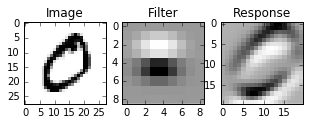

In [2]:
img = images[1,:,:]/255
img = img - np.mean(img.flatten())
img = img/np.sqrt(np.sum(img.flatten()**2.0))

f = 9
d = img.shape[0]
r = gabor_patch(f,0.1,1/4*np.pi,1.5,0.01) + 0.01

# really slow
W = np.zeros([d*d,(d-f+1)*(d-f+1)])
for i in range(d-f+1):
    for j in range(d-f+1):
        for k in range(f):
            for l in range(f):
                W[(i+k)*d+j+l,i*(d-f+1)+j] = r[k,l]
        
beta_really_slow = np.dot(img.flatten(),W).reshape((d-f+1,d-f+1))
                
# slow
beta_slow = np.zeros((d-f+1,d-f+1))
for i in range(d-f+1):
    for j in range(d-f+1):
        patch = img[i:i+f,j:j+f]
        beta_slow[i,j] = np.dot(patch.flatten(),r.flatten())

# fast
beta = scipy.signal.convolve2d(img,np.flipud(np.fliplr(r)),mode='valid')
pyplot.figure(figsize=(5,20))

pyplot.subplot(1,3,1)
gray_plot(img,new_figure=False)
pyplot.title('Image')

pyplot.subplot(1,3,2)
gray_plot(r,new_figure=False)
pyplot.title('Filter')

pyplot.subplot(1,3,3)
gray_plot(beta,new_figure=False)
pyplot.title('Response')
np.sum((beta - beta_slow)**2.0),np.sum((beta - beta_really_slow)**2.0)


## Deconvolution

**Problem 1 (1pt)** Deconvolution can be seen as an operation of reconstructing the input, $\xx$, to convolution  given the response $\bbeta$ and filter $\WW$
$$
\hat{\xx} = \argmin_{\xx} \frac{1}{2}\norm{\xx\WW - \bbeta}^2 
$$
In effect, find $\hat{\xx}$ such that its convolution with the filter matches $\bbeta$.
Since the size of $\xx$ is typically larger than $\bbeta$ there are many possible solutions and we need to regularize
$$
\hat{\xx} = \argmin_{\xx} \frac{1}{2}\norm{\xx\WW - \bbeta}^2  + \frac{\lambda}{2}\norm{\xx}^2
$$
Closed form solution is
$$
\hat{\xx} = \beta\DD
$$
where
$$
\DD = (\WW^T\WW)^{-1}(\WW)^T
$$

To check your answer assume that 
$$\begin{array}{rcrcll}
\textrm{variable} && \textrm{rows} && \textrm{columns} & \\
\hline
\xx &:& d*d &\times& 1 &\textrm{(a vector)}\\
\WW &:& (d*d) &\times& ((d-f+1)*(d-f+1))& \textrm{(a matrix)}\\
\bbeta&:& ((d-f+1)*(d-f+1)) &\times& 1 &\textrm{(a vector)},
\end{array}
$$ where we note that $m \times n$ indicates a matrix with $m$ rows and $n$ columns. Hence $\WW$ has $(d*d)$ rows and $ (d-f+1)*(d-f+1)$ columns. Using these sizes and rules of matrix vector multiplication ensure that $\hat{\xx}$ has the size of $ d*d \times 1$

**Hint**: you will find that solution is of form
$$
\DD = \CC\WW^T
$$ where $\CC$ is another matrix.

**Note 1**: the matrix $\DD$ you derived above is also known as pseudo-inverse of $\WW$.

**Note 2**: the reconstruction will not be exactly the same as the original image. After all we used only one filter which detected changes in intensity from black to white going upward. If you did this correctly you should see error of about 0.2.


**Problem 2 (1pt)** Implement solution for $\hat{\xx}$ from ```beta``` and matrix ```W``` we computed above.

image norm: 1.0 Reconstruction norm: 0.792098778101 Error norm: 0.207901221903


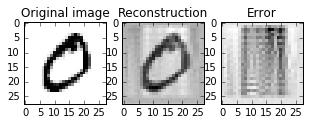

In [3]:
recon = np.zeros(img.shape)
count = np.zeros(img.shape)

C = np.linalg.inv(np.dot(W.transpose(),W))
dW = np.dot(C,W.transpose())
recon = np.dot(beta.flatten(),dW)
recon = recon.reshape(28,28)
pyplot.figure(figsize=(5,20))
pyplot.subplot(1,3,1)
gray_plot(img,new_figure=False)
pyplot.title('Original image')

pyplot.subplot(1,3,2)
gray_plot(recon,new_figure=False)
pyplot.title('Reconstruction')

pyplot.subplot(1,3,3)
gray_plot(img - recon,new_figure=False)
pyplot.title('Error')
print('image norm:',np.sum(img**2.0),'Reconstruction norm:',np.sum(recon**2.0),'Error norm:',np.sum((img - recon)**2.0))

---
Convolution can be expressed as matrix multiplication
$$
\conv(\xx,\rr) = \bbeta = \xx\WW
$$
where $\WW$ can be obtained from filter $\rr$.

Deconvolution operation cannot be expressed as multiplication by
a matrix obtained from a filter. Consequently, deconvolution is not equivalent to convolution by another filter.

One way to understand this intuitively is to consider what the convolution and deconvolution do at a single offset:
* convolution summarizes a patch at the offset into a single value in response 
* deconvolution takes a single value at the offest in response and recreates a patch.

Further the actual computation of matrix $\DD$ requires matrix inversion which will couple different entries in $\DD$ and remove parameter regularity and sparsity characteristic of matrix $\WW$.

---
## Transposed convolution
Rather than implementing deconvolution exactly, we can imagine a situation in which
we can approximate the deconvolution matrix by
$$
\DD \approx \WW^T\II  = \WW^T.
$$

$\WW^T$ matches the dimensionality of the true matrix $\DD$. Note that $\WW^T$ is not a matrix representation of  a filter -- transposition ruins that.

However, this type of object -- transpose of a matrix representation of a filter --  can be computed as a gradient of convolutional operation
$$
\WW^T = \nabla_{\xx} \conv(\xx,\ss) = \nabla_{\xx} \xx\WW
$$
Thus, we can express our approximate deconvolution operation -- transposed convolution -- as
$$
\deconv(\bbeta,\ss) = \bbeta\nabla_{\xx}\conv(\xx,\ss).
$$
This operation is called transposed convolution. 

We could optimize filter $\ss$ such that deconvolved image is close to original
$$
\frac{1}{2}\norm{\xx - \deconv(\conv(\xx,\rr),\ss)}^2
$$
Accuracy of the reconstruction will depend on 
* filter $\rr$'s structure -- even with exact deconvolution the image may not be exactly reconstructable  
* accuracy of our assumption that transposed convolution for some filter $\ss$ is close enough to deconvolution for $\rr$

**Problem 3 (0.5pt)** Complete the code below by implementing the reconstruction cost and computing the gradients using theano. Hint: Reconstruction error should be around 0.35.

/home/ec2-user/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:29: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.


(1, 1, 28, 28)
(1, 1, 9, 9)
image norm: 1.0 Error norm: 0.352599125633


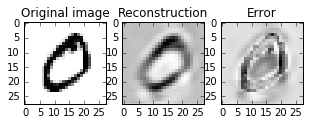

In [4]:
import theano
import theano.tensor as T
import theano.tensor.signal.conv as conv
import theano.tensor.nnet.abstract_conv as abstract_conv
from theano.tensor.nnet import relu
from theano.tensor.nnet.sigm import sigmoid

def make_shared(name,value):
    if type(value) is np.ndarray:
        value = value.astype('float32')
    else:
        value = np.float32(value)
    return theano.shared(name=name,value=value)

def trconv(output, filters, output_shape, filter_size, subsample=(1, 1), border_mode=(0, 0)):
    f1, f2 = (filter_size[0], filter_size[1])
    a1 = 1
    a2 = 1
    o_prime1 = subsample[0] * (output_shape[2] - 1) + a1 + f1 - 2 * border_mode[0]
    o_prime2 = subsample[1] * (output_shape[3] - 1) + a2 + f2 - 2 * border_mode[1]
    input_shape = (None, None, o_prime1, o_prime2)
    input = abstract_conv.conv2d_grad_wrt_inputs(
        output, filters, input_shape=input_shape, filter_shape=None,
        subsample=subsample, border_mode=border_mode)
    return input


img4 = img.astype('float32').reshape(1,1,d,d)
xv = T.dtensor4('x')
xv = xv.astype('float32')
r4 = r.reshape(1,1,f,f)
rv = make_shared('r',value=r4)
hv = T.nnet.conv2d(xv,rv, input_shape = img4.shape, filter_shape = r4.shape,
                   filter_flip=False,border_mode=(0,0))

# tranposed convolution computed via gradient of
# convolution
# this operation creates a reconstruction, y, 
# from filter responses in hv.
sv = make_shared('s',value=r.reshape((1,1,f,f)))
print(img4.shape)
print(r4.shape)
#y = deconv(hv,sv,input_shape=img4.shape,filter_shape=r4.shape)
y = trconv(hv,sv,output_shape=(None,None,d-f,d-f),filter_size=(f,f))
recon_cost = T.mean((xv-y)**2) 
weight_decay =  0.1*T.mean(sv.flatten()**2.0)
cost = recon_cost + weight_decay
gsv = T.grad(cost,sv)
train = theano.function(inputs=[xv],outputs=cost,updates=[(sv,sv-gsv)])

for it in range(1000):
    train(img4)
    
pyplot.figure(figsize=(5,20))    
yrecon = y.eval({xv:img4}).reshape((d,d))
pyplot.subplot(1,3,1)
gray_plot(img,new_figure=False)
pyplot.title('Original image')

pyplot.subplot(1,3,2)
gray_plot(yrecon,new_figure=False)
pyplot.title('Reconstruction')

pyplot.subplot(1,3,3)
gray_plot(img - yrecon,new_figure=False)
pyplot.title('Error')
print('image norm:',np.sum(img**2.0),'Error norm:',np.sum((img - yrecon)**2.0))

# Building a generative deconvolution network

We saw how a digit can be reconstructed from filter responses, either using a exact deconvolution or transposed convolution. Transposed convolution is computationally easier.

We can imagine a generative model that generates filter responses and from those responses using a deconvolution generates an image.

**Problem 4 (1pt)** Implement generator by plugging in the hidden variables and weights. Hint: if the sizes mismatched, theano will complain.

In [5]:
def gen(Z, w,  w2, w3, wx):
    h = relu(batchnorm(T.dot(Z,w)))
    h2 = relu(batchnorm(T.dot(h,w2)))
    h2 = h2.reshape((h2.shape[0], ngf*2, 7, 7))
    h3 = relu(batchnorm(trconv(h2,w3, output_shape=(None,None,7,7),filter_size=(5,5),subsample=(2, 2), border_mode=(2, 2))))
    x = sigmoid(trconv(h3,wx, output_shape=(None, None, 14, 14),
                                   filter_size=(5, 5), subsample=(2, 2), border_mode=(2, 2)))
    return x

**Problem 5 (1pt)** Implement discriminator by plugging in the hidden variables and weights. Hint: if the sizes mismatched, theano will complain.

In [6]:
def discrim(X, w, w2, w3, wy):    
    h = relu(abstract_conv.conv2d(X,w,subsample=(2, 2), border_mode=(2, 2)),alpha=0.2)
    h2 = relu(batchnorm(abstract_conv.conv2d(h,w2,subsample=(2, 2), border_mode=(2, 2))),alpha=0.2)
    h2 = T.flatten(h2, 2)    
    h3 = relu(batchnorm(T.dot(h2,w3)),alpha=0.2)
    y = sigmoid(T.dot(h3,wy))
    return y

**Problem 6 (1pt)** Implement cost for discriminator and generator of the GAN.

In [7]:

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
nbatch = 128      # # of examples in batch
npx = 28          # # of pixels width/height of images
nz = 100          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 64          # # of gen filters in first conv layer
ndf = 64          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 100       # # of iter at starting learning rate
niter_decay = 100 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam


gw  = make_shared('gw',0.02*np.random.randn(nz, ngfc))
gw2 = make_shared('gw2',0.02*np.random.randn(ngfc, ngf*2*7*7) )
gw3 = make_shared('gw3',0.02*np.random.randn(ngf*2, ngf, 5, 5) )
gwx = make_shared('gwx',0.02*np.random.randn(ngf, nc, 5, 5) )

dw  = make_shared('dw',0.02*np.random.randn(ndf, nc, 5, 5))
dw2 = make_shared('dw2',0.02*np.random.randn(ndf*2, ndf, 5, 5))
dw3 = make_shared('dw3',0.02*np.random.randn(ndf*2*7*7, ndfc))
dwy = make_shared('dwy',0.02*np.random.randn(ndfc, 1))

gen_params = [gw, gw2, gw3, gwx]
discrim_params = [dw, dw2, dw3, dwy ]
X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

p_real = discrim(X, *discrim_params)
p_gen = discrim(gX, *discrim_params)

g_cost = (T.log(1-p_gen)).mean()
d_cost = (-T.log(p_real)).mean() + (-T.log(1-p_gen)).mean()

for p in discrim_params:
    d_wd = T.sum(p.flatten()**2.0)

for p in gen_params:
    g_wd = T.sum(p.flatten()**2.0)
    
cost = [g_cost, d_cost]

lrt = make_shared('lrt',lr)
d_updates = adam(d_cost+l2/2*d_wd,discrim_params,beta1=b1,learning_rate=lrt)
g_updates = adam(g_cost+l2/2*g_wd,gen_params,beta1=b1,learning_rate=lrt)
updates = d_updates + g_updates

t = time()
train_g = theano.function([X, Z], cost, updates=g_updates)
train_d = theano.function([X, Z], cost, updates=d_updates)
gen = theano.function([Z], gX)


In [8]:
niter = 25       # # of iter at starting learning rate
niter_decay = 25 # # of iter to linearly decay learning rate to zero

 **Problem 7 (0.5pt)** Run your code.Every 5 iterations the code will show an image of 200 generated digits.
 If the generated images in later epochs look like digits then you are successful.

1 -0.5490709543228149 1.1357417106628418 0.521361
6 -0.38680174946784973 0.7890397906303406 0.0915294
11 -0.5610911250114441 0.9976963996887207 0.109019
16 -0.36514702439308167 0.924572229385376 0.0781361
21 -0.45043036341667175 1.0187729597091675 0.0901157
26 -0.505135715007782 0.9886329174041748 0.0882108
31 -0.5791091918945312 0.9750018119812012 0.101425


KeyboardInterrupt: 

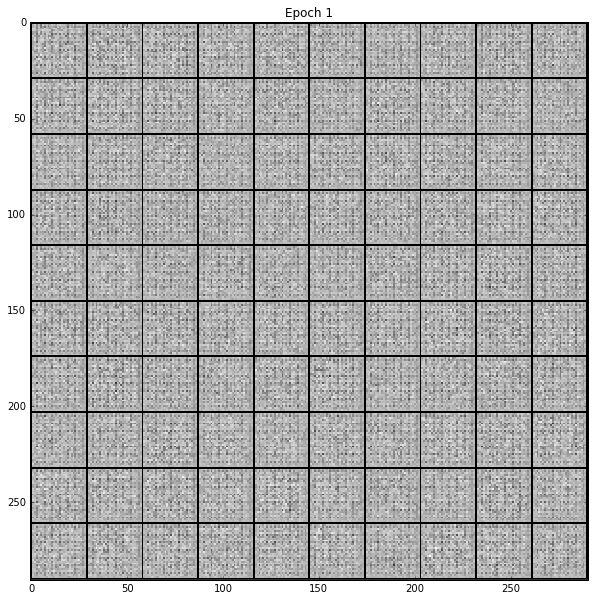

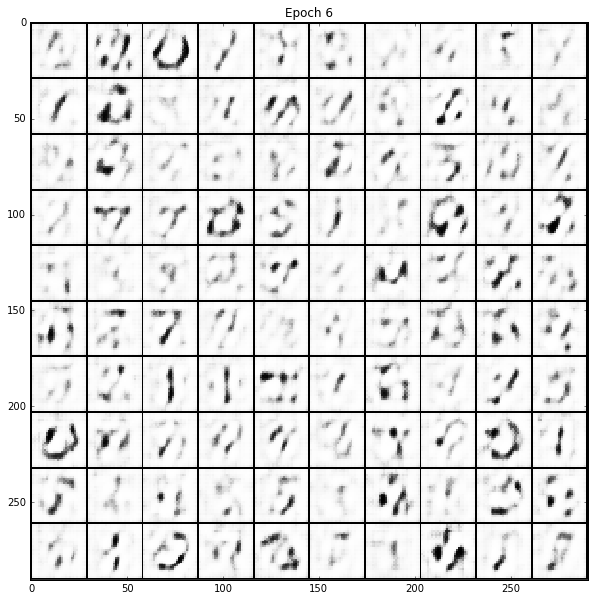

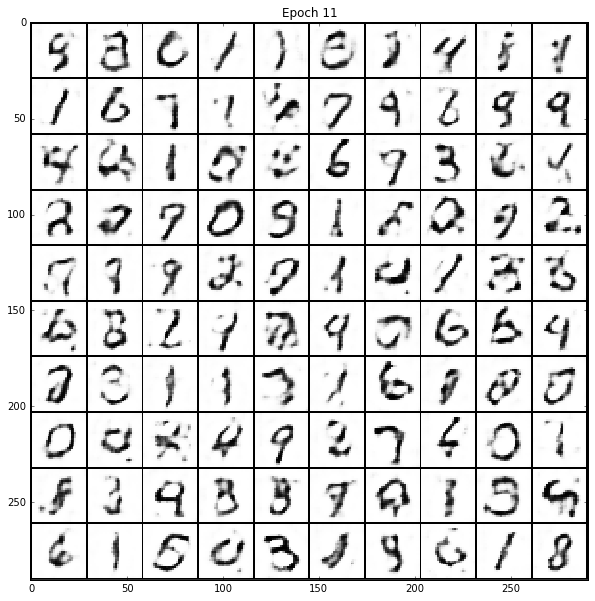

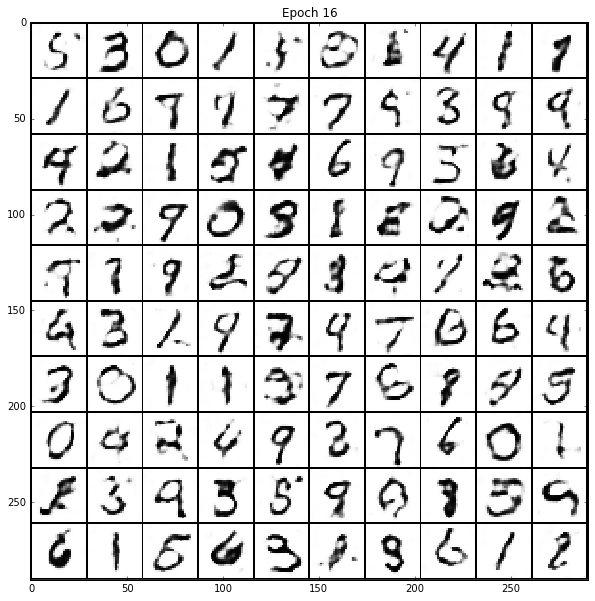

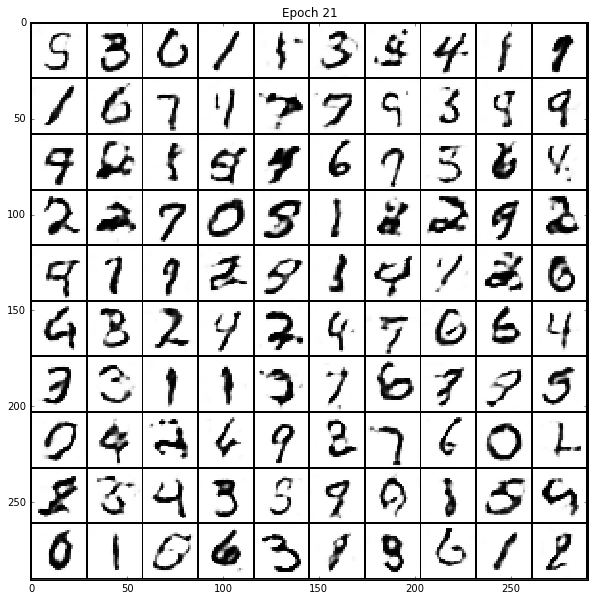

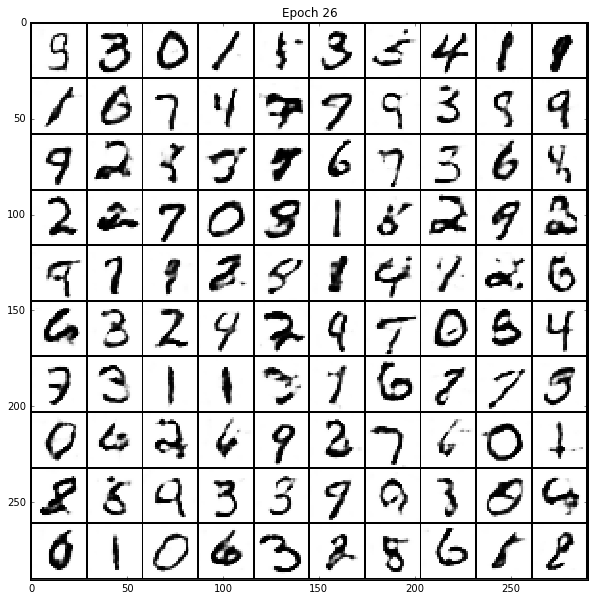

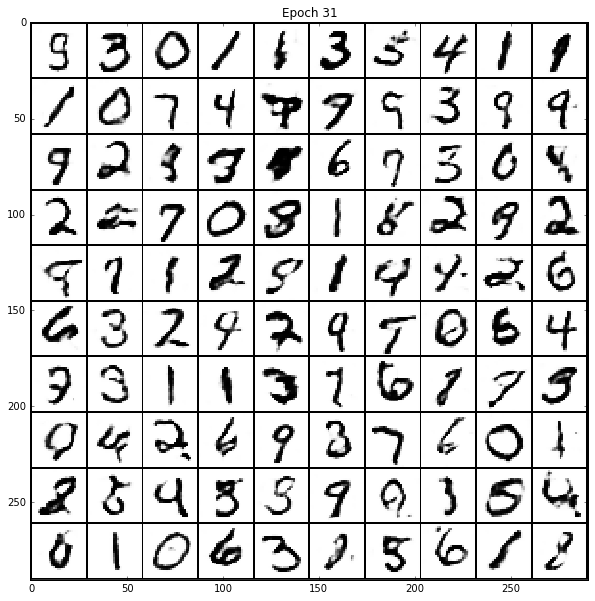

In [ ]:

n_updates = 0
ntrain = images.shape[0]

vis_zbatch = np.float32(np_rng.uniform(-1., 1., size=(100, nz)))

for epoch in range(1, niter+niter_decay+1):
    images = shuffle(images)
    for i in range(0,ntrain,ntrain//nbatch):
        im_batch = transform(images[i:i+nbatch].reshape(-1,1,28,28))
        z_batch = np.float32(np_rng.uniform(-1., 1., size=(len(im_batch), nz)))
        if n_updates % (k+1) == 0:
            cost = train_g(im_batch, z_batch)
        else:
            cost = train_d(im_batch, z_batch)
        n_updates += 1
        
    samples = np.asarray(gen(vis_zbatch))
    
    if (epoch-1) % 5 == 0:        
        g_cost = float(cost[0])
        d_cost = float(cost[1])
        print(epoch,g_cost,d_cost,np.abs(samples[0]).mean())
        show_examples(samples.squeeze(),h=28,w=28)
        pyplot.title('Epoch ' + str(epoch))
            
    if epoch > niter:
        lrt.set_value(np.float32(lrt.get_value() - lr/niter_decay))
    
    